### Importing Libraries

In [19]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import torch
from facenet_pytorch import InceptionResnetV1
from tqdm import tqdm
import torch.nn.functional as F


### Creating and Processing my Dataset from VGG_Face2

In [20]:
dataset_path = '../1/'  # Adjust this to your actual path
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')

In [21]:
"""
def create_pairs(data_path, num_pairs=1000):
    pairs = []
    labels = []

    # Get a list of all person folders and shuffle them for variety
    person_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    random.shuffle(person_dirs)  # Shuffle the folders for a more random selection

    # Calculate approximate number of pairs per person for positive pairs
    pairs_per_person = max(1, num_pairs // (2 * len(person_dirs)))

    # Create positive pairs (same person)
    for person in person_dirs:
        images = os.listdir(os.path.join(data_path, person))
        if len(images) < 2:
            continue  # Skip if not enough images to form pairs

        # Shuffle images for each person to increase randomness
        random.shuffle(images)

        # Generate positive pairs, ensuring each folder contributes some pairs
        for _ in range(pairs_per_person):
            if len(images) < 2:
                break  # Break if not enough images to sample
            img1, img2 = random.sample(images, 2)
            pairs.append((os.path.join(data_path, person, img1),
                          os.path.join(data_path, person, img2)))
            labels.append(0)  # Label 0 for same person

    # Shuffle persons again to create more variety in negative pairs
    random.shuffle(person_dirs)

    # Create negative pairs (different persons)
    for _ in range(num_pairs - len(pairs)):  # Fill remaining pairs as negative
        person1, person2 = random.sample(person_dirs, 2)  # Pick two different persons
        img1 = random.choice(os.listdir(os.path.join(data_path, person1)))
        img2 = random.choice(os.listdir(os.path.join(data_path, person2)))
        pairs.append((os.path.join(data_path, person1, img1),
                      os.path.join(data_path, person2, img2)))
        labels.append(1)  # Label 1 for different persons

    # Shuffle the final pairs list to mix positive and negative pairs
    combined = list(zip(pairs, labels))
    random.shuffle(combined)
    pairs, labels = zip(*combined)

    return pairs, labels
"""

'\ndef create_pairs(data_path, num_pairs=1000):\n    pairs = []\n    labels = []\n\n    # Get a list of all person folders and shuffle them for variety\n    person_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]\n    random.shuffle(person_dirs)  # Shuffle the folders for a more random selection\n\n    # Calculate approximate number of pairs per person for positive pairs\n    pairs_per_person = max(1, num_pairs // (2 * len(person_dirs)))\n\n    # Create positive pairs (same person)\n    for person in person_dirs:\n        images = os.listdir(os.path.join(data_path, person))\n        if len(images) < 2:\n            continue  # Skip if not enough images to form pairs\n\n        # Shuffle images for each person to increase randomness\n        random.shuffle(images)\n\n        # Generate positive pairs, ensuring each folder contributes some pairs\n        for _ in range(pairs_per_person):\n            if len(images) < 2:\n                break  # Brea

In [22]:

"""
# Generate training pairs
train_pairs, train_labels = create_pairs(train_path, num_pairs=2000000)
# Generate validation pairs
val_pairs, val_labels = create_pairs(val_path, num_pairs=500000)
"""

'\n# Generate training pairs\ntrain_pairs, train_labels = create_pairs(train_path, num_pairs=2000000)\n# Generate validation pairs\nval_pairs, val_labels = create_pairs(val_path, num_pairs=500000)\n'

In [23]:
"""


def save_pairs_to_sqlite(pairs, labels, db_file):
    conn = sqlite3.connect(db_file)
    c = conn.cursor()
    
    # Create table if it doesn't exist
    c.execute('''
        CREATE TABLE IF NOT EXISTS image_pairs (
            image1 TEXT,
            image2 TEXT,
            label INTEGER
        )
    ''')

    # Insert data into the table
    c.executemany('INSERT INTO image_pairs (image1, image2, label) VALUES (?, ?, ?)', 
                  [(pair[0], pair[1], label) for pair, label in zip(pairs, labels)])

    conn.commit()
    conn.close()


"""

"\n\n\ndef save_pairs_to_sqlite(pairs, labels, db_file):\n    conn = sqlite3.connect(db_file)\n    c = conn.cursor()\n    \n    # Create table if it doesn't exist\n    c.execute('''\n        CREATE TABLE IF NOT EXISTS image_pairs (\n            image1 TEXT,\n            image2 TEXT,\n            label INTEGER\n        )\n    ''')\n\n    # Insert data into the table\n    c.executemany('INSERT INTO image_pairs (image1, image2, label) VALUES (?, ?, ?)', \n                  [(pair[0], pair[1], label) for pair, label in zip(pairs, labels)])\n\n    conn.commit()\n    conn.close()\n\n\n"

In [24]:
"""

save_pairs_to_sqlite(train_pairs, train_labels, 'train_pairs.db')
save_pairs_to_sqlite(val_pairs, val_labels, 'val_pairs.db')

"""

"\n\nsave_pairs_to_sqlite(train_pairs, train_labels, 'train_pairs.db')\nsave_pairs_to_sqlite(val_pairs, val_labels, 'val_pairs.db')\n\n"

### Creating custom Model

In [25]:
# Instantiate model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Residual connection
        return self.relu(out)


In [27]:

model = InceptionResnetV1(pretrained='vggface2')
print(model)


InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [28]:


class SiameseFaceNet(nn.Module):
    def __init__(self, embedding_size=512, additional_features_size=256):
        super(SiameseFaceNet, self).__init__()
        
        # Load the pre-trained model
        self.base_model = InceptionResnetV1(pretrained='vggface2')
        
        # Find the input convolution layer and modify it
        # Assuming the first layer is a Conv2d layer and the model uses a sequential architecture
        if isinstance(self.base_model, nn.Sequential):
            self.base_model[0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=0)
        else:
            # If not a Sequential model, try to locate and modify the appropriate layer
            self.base_model.conv2d_1a = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=0)
        
        # Additional convolutional layers
        self.conv1 = nn.Conv2d(embedding_size, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Residual blocks
        self.res_block1 = ResidualBlock(128, 128)
        self.res_block2 = ResidualBlock(128, 128) 

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        
        self.fc2 = nn.Linear(1024, additional_features_size)

    def forward_one(self, x):
        # Pass through the base FaceNet model
        x = self.base_model(x)

        # Reshape to include spatial dimensions
        x = x.unsqueeze(-1).unsqueeze(-1)

        # Additional convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        # Residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)

        # Global average pooling
        x = F.adaptive_avg_pool2d(x, (4, 4))

        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

    def forward(self, input1, input2):
        # Process each input separately
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)

        return output1, output2


In [29]:
class SiameseDataset(Dataset):
    """Dataset for Siamese Network using pre-created SQLite pairs."""
    def __init__(self, db_file, transform=None):
        self.transform = transform
        self.pairs = self.load_pairs(db_file)

    def load_pairs(self, db_file):
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query("SELECT image1, image2, label FROM image_pairs", conn)
        conn.close()
        return list(zip(df['image1'], df['image2'], df['label']))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):
        img1_path, img2_path, label = self.pairs[index]
        
        # Load images
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)


In [30]:
# Define contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss


### Training My custom Model

In [31]:

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),  # Ensure the image is grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [32]:

# Load the datasets with transforms
train_dataset = SiameseDataset('train_pairs.db', transform=transform)
val_dataset = SiameseDataset('val_pairs.db', transform=transform)
len(train_dataset)


32768

In [33]:
"""
import matplotlib.pyplot as plt
from collections import Counter

# Assuming labels can be accessed with dataset[i][1] (adjust if different)
def get_label_counts(dataset):
    labels = [dataset[i][2] for i in range(len(dataset))]
    label_counts = Counter(labels)
    return label_counts

# Get label counts for the combined dataset
label_counts = get_label_counts(val_dataset)

# Calculate ratios
total = sum(label_counts.values())
label_ratios = {label: count / total for label, count in label_counts.items()}

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(label_ratios.keys(), label_ratios.values(), color=['blue', 'orange'])
plt.xticks([0, 1], labels=['Match', 'No Match'])
plt.xlabel("Labels")
plt.ylabel("Ratio")
plt.title("Ratio of 0 and 1 in Labels")
plt.show()
"""


'\nimport matplotlib.pyplot as plt\nfrom collections import Counter\n\n# Assuming labels can be accessed with dataset[i][1] (adjust if different)\ndef get_label_counts(dataset):\n    labels = [dataset[i][2] for i in range(len(dataset))]\n    label_counts = Counter(labels)\n    return label_counts\n\n# Get label counts for the combined dataset\nlabel_counts = get_label_counts(val_dataset)\n\n# Calculate ratios\ntotal = sum(label_counts.values())\nlabel_ratios = {label: count / total for label, count in label_counts.items()}\n\n# Plotting\nplt.figure(figsize=(6, 4))\nplt.bar(label_ratios.keys(), label_ratios.values(), color=[\'blue\', \'orange\'])\nplt.xticks([0, 1], labels=[\'Match\', \'No Match\'])\nplt.xlabel("Labels")\nplt.ylabel("Ratio")\nplt.title("Ratio of 0 and 1 in Labels")\nplt.show()\n'

In [34]:
# Create dataloaders
batch_size = 512  # Adjust according to your GPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Loading model from save

In [35]:
model = SiameseFaceNet().to(device)
# Load the state dictionary (trained parameters) into the model
#model.load_state_dict(torch.load("FR_model.pth"))

# Move the model to the appropriate device (CPU or GPU)
model.to(device)

print("Model loaded successfully.")

Model loaded successfully.


In [36]:
# Instantiate model, loss function, and optimizer
criterion = ContrastiveLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [37]:
def validate_model():
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            running_val_loss += loss.item()

    print(f"Validation Loss: {running_val_loss/len(val_loader):.4f}")

In [38]:
# Define the training loop
def train_model( num_epochs):
    varlen=len(train_loader)
    for epoch in range(num_epochs):
        # Training phase
        subepoch=0
        model.train()
        running_loss = 0.0
        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            subepoch+=1
            #print(f"Epoch [{epoch+1}]: subEpoch [{subepoch}/{varlen}], Loss: {loss.item()}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/varlen}")   

In [22]:
train_model(num_epochs=500)

KeyboardInterrupt: 

In [39]:
# Validation phase
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
with torch.no_grad():  # Disable gradient calculation for validation
    for img1, img2, label in val_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        # Forward pass
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label)

        val_loss += loss.item()

# Print the average validation loss
print(f"Validation Loss: {val_loss/len(val_loader)}")


Validation Loss: 2.123345375061035


### Saving and Loading Model

In [40]:
# Specify the path where the model will be saved
model_save_path = "FR_model.pth"

# Save the model's state dictionary (this contains the trained parameters)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to FR_model.pth


### Testing The model with Real Imaged

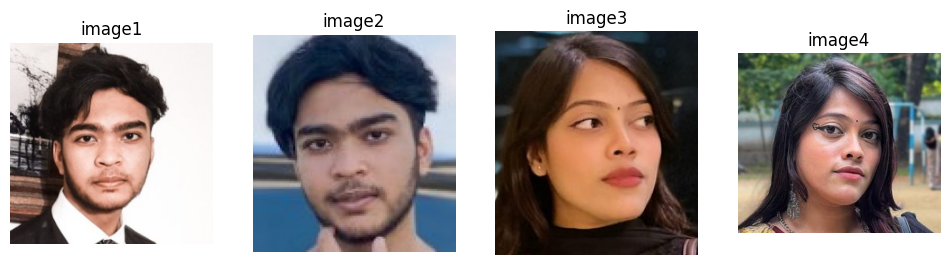

In [41]:
# Load images individually
image1 = Image.open('rafid1.jpg').convert('RGB')
image2 = Image.open('rafid2.jpg').convert('RGB')
image3 = Image.open('rathri1.jpg').convert('RGB')
image4 = Image.open('rathri2.jpg').convert('RGB')

# Display the images using matplotlib
plt.figure(figsize=(12, 6))

# Show Image 1
plt.subplot(1, 4, 1)
plt.imshow(image1)
plt.title('image1')
plt.axis('off')

# Show Image 2
plt.subplot(1, 4, 2)
plt.imshow(image2)
plt.title('image2')
plt.axis('off')

# Show Image 3
plt.subplot(1, 4, 3)
plt.imshow(image3)
plt.title('image3')
plt.axis('off')

# Show Image 4
plt.subplot(1, 4, 4)
plt.imshow(image4)
plt.title('image4')
plt.axis('off')

plt.show()

In [42]:

def predict_similarity(siamese_network, image1, image2, threshold=0.5):

   # Define the transformations
    # Define the transformations
    transform = transforms.Compose([
                transforms.Resize((128, 128)),  # Resize images to a fixed size
                transforms.Grayscale(num_output_channels=1),  # Ensure the image is grayscale
                transforms.GaussianBlur(kernel_size=5, sigma=0.2),  # Apply Gaussian blur with sigma=0.2
                transforms.ToTensor(),  # Convert images to PyTorch tensors
                transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize grayscale images (adjust the values as needed)
])
    image1 = transform(image1).unsqueeze(0).to(device)  # Add batch dimension and move to device
    image2 = transform(image2).unsqueeze(0).to(device)

    # Ensure the model is in evaluation mode
    siamese_network.eval()

    # Disable gradient calculation for inference
    with torch.no_grad():
        # Pass both images through the Siamese Network
        output1, output2 = siamese_network(image1, image2)
        
        # Calculate the Euclidean distance between the embeddings
        distance =torch.nn.functional.pairwise_distance(output1, output2)
        
        # Check if the distance is less than the threshold
        if distance.item() < threshold:
            return True  # Images are of the same person
        else:
            return False  # Images are of different people


In [43]:
#should be true
print(predict_similarity(model, image1, image2, threshold=0.5))
print(predict_similarity(model, image3, image4, threshold=0.5))
print("\n")
#should be False
print(predict_similarity(model, image1, image4, threshold=0.5))
print(predict_similarity(model, image2, image3, threshold=0.5))
print(predict_similarity(model, image1, image3, threshold=0.5))
print(predict_similarity(model, image2, image4, threshold=0.5))


True
True


True
True
True
True
